# SQLAlchemy Practice on a Business Database:  

---

By Jean-Yves Tran | jy.tran@[datascience-jy.com](https:datascience-jy.com) | [LinkedIn](https://www.linkedin.com/in/jytran-datascience/)  
IBM Certified Data Scientist 

---

Using PostGreSQL database of a real world business - a DVD rental - I practiced on:

- the essential SQL commands: 
  - joining [3 tables](#join-3-tables)
  - [distinct](#cte-1)
  - [union](#union) on 2 selects of a date range, with literal to create a new column
  - extract to filter out days, months, hours from dates
- some specific commands: 
  - [agg_array](#agg-array) for dates, 
  - [generate_series()](#gen-series) to filter on a specific date range
  - [aliasing](#aliasing) for subqueries
- some complex commands like:
  - a correlated subquery (see ["First Rental Date of each client"](#corr-subq))
  - a CTE (common table expression) - [see Clients with rentals from multiple stores](#cte-1)
  - aliasing 2 date series as subqueries for a select with an outerjoin ([click here](#aliasing))
- using the SQL toolkit SQLAlchemy and its Core approach.

In the last chapter of TASKS, I drill down on queries to successfully select very specific customers.  
While this database has over 16.000 entries, I only touch on 6 of the 15 tables. 

---


#### Imports

In [2]:
from sqlalchemy import create_engine, cast, alias, select, and_, extract, union, literal, nullsfirst, func, Time, Table, MetaData, Date
from datetime import date
from dotenv import load_dotenv
import os
from pathlib import Path


---


In [3]:
# Get the current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

Current working directory: f:\DATA Scientist\VSCODE_DataScience_JyTRAN\Data_ML_Practice_2025\1-3-SQL\practice\dvd_rental


### .env file:  

Securing PostGreSQL credentials.

In [5]:
# Get the current working directory
current_dir = os.getcwd()

# Construct the path to the .env file
env_path = Path(current_dir).parents[2] / ".env"
print(f".env file exists: {env_path.exists()}")

# Load environment variables from the .env file
load_dotenv(dotenv_path=env_path)

.env file exists: True


True


---


### Setup of the Connection:

Connecting to the PostGreSQL database dvdrental using SQLAlchemy Core approach. 

In [6]:
# Define the PostgreSQL database URL from environment variables
DATABASE_URL = os.getenv("DATABASE_URL")

# Create the SQLAlchemy engine
engine = create_engine(DATABASE_URL)

# Create a MetaData instance
metadata_obj = MetaData()


---


### Reflecting a Table:  

 Reflecting allows me to fetch a table's schema without manually defining columns and their data types.  

 Reflection saves time and effort because I  don't need to manually define all the columns of the table in Python code.

In [7]:
payment = Table('payment', metadata_obj, autoload_with=engine)


---


<a id="er-diagram"></a>
## ER Diagram of the dvdrental database: 
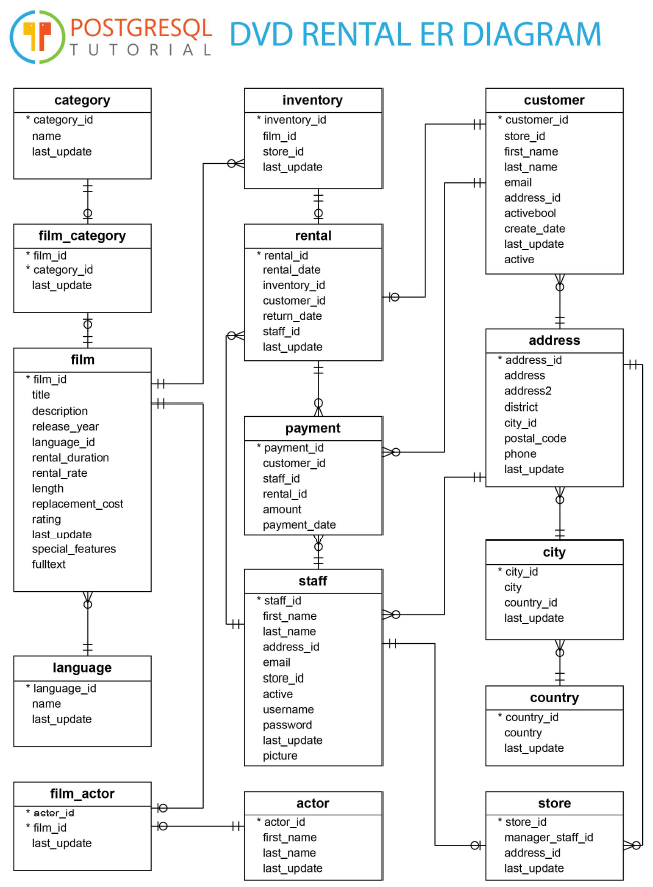


---


## TASKS:

### First Query:  

I start querying the database using PostGreSQL. First I want to look at the payment table.

In [8]:
with engine.connect() as conn:
    stmt_0 = select(
        payment
        ).limit(10)
    
    result = conn.execute(stmt_0)
    
    # Print column names
    print(" | ".join(result.keys()))  # result.keys() returns a list of column names as strings
    
    for row in result:
        print(row)

payment_id | customer_id | staff_id | rental_id | amount | payment_date
(17503, 341, 2, 1520, Decimal('7.99'), datetime.datetime(2007, 2, 15, 22, 25, 46, 996577))
(17504, 341, 1, 1778, Decimal('1.99'), datetime.datetime(2007, 2, 16, 17, 23, 14, 996577))
(17505, 341, 1, 1849, Decimal('7.99'), datetime.datetime(2007, 2, 16, 22, 41, 45, 996577))
(17506, 341, 2, 2829, Decimal('2.99'), datetime.datetime(2007, 2, 19, 19, 39, 56, 996577))
(17507, 341, 2, 3130, Decimal('7.99'), datetime.datetime(2007, 2, 20, 17, 31, 48, 996577))
(17508, 341, 1, 3382, Decimal('5.99'), datetime.datetime(2007, 2, 21, 12, 33, 49, 996577))
(17509, 342, 2, 2190, Decimal('5.99'), datetime.datetime(2007, 2, 17, 23, 58, 17, 996577))
(17510, 342, 1, 2914, Decimal('5.99'), datetime.datetime(2007, 2, 20, 2, 11, 44, 996577))
(17511, 342, 1, 3081, Decimal('2.99'), datetime.datetime(2007, 2, 20, 13, 57, 39, 996577))
(17512, 343, 2, 1547, Decimal('4.99'), datetime.datetime(2007, 2, 16, 0, 10, 50, 996577))



---


### Refactoring & Better Output:  

I will use this `with` statement a lot, so it'd be better to turn it into a function.  
Also I want basic information to be printed in the output:  
- total number of rows returned
- the translation of the statement in raw SQL (help in error checking)
- column names: 
  - filtering dates and formatting them
  - separated by a pipe |

In [9]:
def execute_stmt(stmt):
    with engine.connect() as conn:
        result = conn.execute(stmt)
        rows = result.fetchall()            # Fetch all rows to calculate total count
        
        # Print the total number of rows returned
        print(f"\nTotal rows returned: {len(rows)}")
        
        print(f"\nRaw SQL query:\n{stmt.compile(engine)}\n")    # Show the equivalent raw-like SQL query
        
        # Print column names
        print(" | ".join(result.keys()))                        # result.keys() returns a list of column names as strings
        
        for row in rows:
            formatted_row = [                        # if date, format as Y-M-D, else as string
                item.strftime("%Y-%m-%d") if isinstance(item, date) else str(item)
                for item in row
            ]
            print(" | ".join(formatted_row))                    # Separate columns with " | "

I run it with the previous stmt_0, which has a LIMIT clause of 10:

In [10]:
execute_stmt(stmt_0)


Total rows returned: 10

Raw SQL query:
SELECT payment.payment_id, payment.customer_id, payment.staff_id, payment.rental_id, payment.amount, payment.payment_date 
FROM payment 
 LIMIT %(param_1)s

payment_id | customer_id | staff_id | rental_id | amount | payment_date
17503 | 341 | 2 | 1520 | 7.99 | 2007-02-15
17504 | 341 | 1 | 1778 | 1.99 | 2007-02-16
17505 | 341 | 1 | 1849 | 7.99 | 2007-02-16
17506 | 341 | 2 | 2829 | 2.99 | 2007-02-19
17507 | 341 | 2 | 3130 | 7.99 | 2007-02-20
17508 | 341 | 1 | 3382 | 5.99 | 2007-02-21
17509 | 342 | 2 | 2190 | 5.99 | 2007-02-17
17510 | 342 | 1 | 2914 | 5.99 | 2007-02-20
17511 | 342 | 1 | 3081 | 2.99 | 2007-02-20
17512 | 343 | 2 | 1547 | 4.99 | 2007-02-16



---


### Checking all Payments:

I want to know:

1. the payment id 
2. along with its customer id,
3. and amount
4. sorted by customer id 
  - in a descending order

In [11]:
# Instancing each attribute I need:
ppid = payment.c.payment_id     # 1.
pcid = payment.c.customer_id    # 2.
pa = payment.c.amount           # 3.

stmt = (
    select(
    ppid,
    pcid,
    pa
    )
    .order_by(                              # 4.
        pcid.desc(), 
        ppid.desc(),  # pcid is sorted first, and within it, ppid is also sorted
        pa
        )  
).limit(10)

execute_stmt(stmt)


Total rows returned: 10

Raw SQL query:
SELECT payment.payment_id, payment.customer_id, payment.amount 
FROM payment ORDER BY payment.customer_id DESC, payment.payment_id DESC, payment.amount 
 LIMIT %(param_1)s

payment_id | customer_id | amount
28910 | 599 | 2.99
28908 | 599 | 2.99
28907 | 599 | 6.99
28906 | 599 | 2.99
28905 | 599 | 9.99
28904 | 599 | 2.99
28903 | 599 | 0.99
22622 | 599 | 2.99
22621 | 599 | 2.99
22620 | 599 | 8.99


#### Total Number of Customers:  

It'be useful to know the total number of customers.

In [12]:
stmt = select(
    func.max(
        payment.c.customer_id
        )
    .label("total_#_customers")
)

execute_stmt(stmt)


Total rows returned: 1

Raw SQL query:
SELECT max(payment.customer_id) AS "total_#_customers" 
FROM payment

total_#_customers
599


#### Only rentals > $1:

We see most rentals are over $0.99. Let's **filter out all rentals under $1**.  
Let's also **label the columns names** now that we now what they refer too.

In [13]:
stmt = (
    select(
    ppid.label("ppid"),
    pcid.label("pcid"),
    pa.label("pa")
    )
    .where(
        pa > 1        # only amounts > 1
    )
    .order_by(
        pcid.desc(), 
        ppid.desc(),  # pcid is sorted first, and within it, ppid is also sorted
        pa
        )  
).limit(10)

execute_stmt(stmt)


Total rows returned: 10

Raw SQL query:
SELECT payment.payment_id AS ppid, payment.customer_id AS pcid, payment.amount AS pa 
FROM payment 
WHERE payment.amount > %(amount_1)s ORDER BY payment.customer_id DESC, payment.payment_id DESC, payment.amount 
 LIMIT %(param_1)s

ppid | pcid | pa
28910 | 599 | 2.99
28908 | 599 | 2.99
28907 | 599 | 6.99
28906 | 599 | 2.99
28905 | 599 | 9.99
28904 | 599 | 2.99
22622 | 599 | 2.99
22621 | 599 | 2.99
22620 | 599 | 8.99
22619 | 599 | 1.99


#### Only February:

From previous execution we noted that most dates are in February. Let's filter out the other months so that we only look at February.

In [14]:
ppd = payment.c.payment_date

stmt = (
    select(
        ppid.label("ppid"),
        pcid.label("pcid"),
        pa.label("pa"),
        ppd.label("ppd")
    )
    .where(
        and_(
            pa > 1,                 # Filter rows where the amount is greater than 1...
            extract(
                "month", ppd) == 2  # ...and the payment date is in February
            )    
        )
    .order_by(
        pcid.desc(), 
        ppid.desc(),  # pcid is sorted first, and within it, ppid is also sorted
        pa
        )  
).limit(10)

execute_stmt(stmt)


Total rows returned: 10

Raw SQL query:
SELECT payment.payment_id AS ppid, payment.customer_id AS pcid, payment.amount AS pa, payment.payment_date AS ppd 
FROM payment 
WHERE payment.amount > %(amount_1)s AND EXTRACT(month FROM payment.payment_date) = %(param_1)s ORDER BY payment.customer_id DESC, payment.payment_id DESC, payment.amount 
 LIMIT %(param_2)s

ppid | pcid | pa | ppd
18467 | 599 | 6.99 | 2007-02-21
18466 | 599 | 4.99 | 2007-02-21
18465 | 599 | 6.99 | 2007-02-20
18464 | 599 | 1.99 | 2007-02-18
18463 | 598 | 2.99 | 2007-02-20
18462 | 597 | 1.99 | 2007-02-20
18461 | 597 | 4.99 | 2007-02-19
18459 | 596 | 1.99 | 2007-02-19
18458 | 596 | 1.99 | 2007-02-16
18457 | 595 | 4.99 | 2007-02-21


#### Total payments per day  

I want to get: 
1. the total count of payments 
2. per day

In [15]:
stmt = (
    select(
        # Raw SQL = payment.payment_date::date
        cast(ppd, Date).label("ppd"),               # 2.              
        func.count(ppid).label("ttal_count_paymt")  # 1.
    )
    .group_by(cast(ppd, Date))
    .order_by(cast(ppd, Date).desc())              
).limit(10)
    
execute_stmt(stmt)


Total rows returned: 10

Raw SQL query:
SELECT CAST(payment.payment_date AS DATE) AS ppd, count(payment.payment_id) AS ttal_count_paymt 
FROM payment GROUP BY CAST(payment.payment_date AS DATE) ORDER BY CAST(payment.payment_date AS DATE) DESC 
 LIMIT %(param_1)s

ppd | ttal_count_paymt
2007-05-14 | 182
2007-04-30 | 1311
2007-04-29 | 640
2007-04-28 | 627
2007-04-27 | 643
2007-04-26 | 79
2007-04-12 | 452
2007-04-11 | 468
2007-04-10 | 482
2007-04-09 | 514


#### Total paid by client: 

I am now curious about the total amount paid by client:  

In [16]:
stmt = (
    select(
        pcid.label("pcid"),
        func.sum(pa).label("ttal_amount")
    )
    .group_by(pcid)
    .order_by(func.sum(pa).desc())
).limit(10)

execute_stmt(stmt)


Total rows returned: 10

Raw SQL query:
SELECT payment.customer_id AS pcid, sum(payment.amount) AS ttal_amount 
FROM payment GROUP BY payment.customer_id ORDER BY sum(payment.amount) DESC 
 LIMIT %(param_1)s

pcid | ttal_amount
148 | 211.55
526 | 208.58
178 | 194.61
137 | 191.62
144 | 189.60
459 | 183.63
181 | 167.67
410 | 167.62
236 | 166.61
403 | 162.67


<a id="agg-array"></a>
#### All payment dates per client:

In [17]:
stmt = (
    select(
        pcid.label("pcid"),
        # an array of payment dates for each customer
        func.array_agg(cast(ppd, Date)).label("paymt_dates")
        )
    .group_by(pcid)
    .order_by(pcid)
)

execute_stmt(stmt)


Total rows returned: 599

Raw SQL query:
SELECT payment.customer_id AS pcid, array_agg(CAST(payment.payment_date AS DATE)) AS paymt_dates 
FROM payment GROUP BY payment.customer_id ORDER BY payment.customer_id

pcid | paymt_dates
1 | [datetime.date(2007, 2, 14), datetime.date(2007, 2, 15), datetime.date(2007, 2, 15), datetime.date(2007, 2, 16), datetime.date(2007, 2, 18), datetime.date(2007, 2, 18), datetime.date(2007, 2, 21), datetime.date(2007, 3, 1), datetime.date(2007, 3, 2), datetime.date(2007, 3, 2), datetime.date(2007, 3, 17), datetime.date(2007, 3, 18), datetime.date(2007, 3, 19), datetime.date(2007, 3, 19), datetime.date(2007, 3, 21), datetime.date(2007, 3, 21), datetime.date(2007, 3, 22), datetime.date(2007, 3, 22), datetime.date(2007, 4, 8), datetime.date(2007, 4, 8), datetime.date(2007, 4, 9), datetime.date(2007, 4, 9), datetime.date(2007, 4, 11), datetime.date(2007, 4, 27), datetime.date(2007, 4, 28), datetime.date(2007, 4, 28), datetime.date(2007, 4, 28), datetime.date(2

#### Getting a specific range of dates:
<a id="gen-series"></a>
I need to zoom in on a specific range of dates. 

In [18]:
# Create a series of dates from 2017-08-01 to the current date
gs = func.generate_series(
    cast("2017-08-01", Date),           # start of the range
    cast(func.current_date(), Date),    # end of the range
    "1 day"                             # interval between dates
)

stmt = (
    select(
        gs.label("dates_series")
        )
    )

execute_stmt(stmt)


Total rows returned: 2745

Raw SQL query:
SELECT generate_series(CAST(%(param_1)s AS DATE), CAST(CURRENT_DATE AS DATE), %(generate_series_1)s) AS dates_series

dates_series
2017-08-01
2017-08-02
2017-08-03
2017-08-04
2017-08-05
2017-08-06
2017-08-07
2017-08-08
2017-08-09
2017-08-10
2017-08-11
2017-08-12
2017-08-13
2017-08-14
2017-08-15
2017-08-16
2017-08-17
2017-08-18
2017-08-19
2017-08-20
2017-08-21
2017-08-22
2017-08-23
2017-08-24
2017-08-25
2017-08-26
2017-08-27
2017-08-28
2017-08-29
2017-08-30
2017-08-31
2017-09-01
2017-09-02
2017-09-03
2017-09-04
2017-09-05
2017-09-06
2017-09-07
2017-09-08
2017-09-09
2017-09-10
2017-09-11
2017-09-12
2017-09-13
2017-09-14
2017-09-15
2017-09-16
2017-09-17
2017-09-18
2017-09-19
2017-09-20
2017-09-21
2017-09-22
2017-09-23
2017-09-24
2017-09-25
2017-09-26
2017-09-27
2017-09-28
2017-09-29
2017-09-30
2017-10-01
2017-10-02
2017-10-03
2017-10-04
2017-10-05
2017-10-06
2017-10-07
2017-10-08
2017-10-09
2017-10-10
2017-10-11
2017-10-12
2017-10-13
2017-10-14
2

#### Joining two ranges of dates:  
<a id="alias"></a>
In the code below I demonstrate a use of a LEFT OUTER JOIN.  
The left table is the date series gs_al. The outer table is the same date series but with 10 days missing on the starting date.  
As a result, this 10 days gap will show in the 1nd date series as None for each of these 10 days.   
In other words, I joined the two dates series AND kept all the dates from the left table that had NO rows to match with the second dates series.  

If I did not use outerjoin to do this LEFT JOIN, the left date series would not have shown dates before the 10th missing day.  
And this called an **INNER JOIN**, **everything that is INSIDE of the two dates series**, that **is in common**, is shown, the rest is not.  
In SQLAlchemy, an INNER JOIN is achieved with .join().

SQLAlchemy cannot compute SELECT with series from generate_series(). For that we need to turn the series into aliases. 

In [19]:
# Define the two range of dates (generate_series) as subqueries so that they can be joined
# First series of dates
gs_al = alias(
    select(func.generate_series(
        cast("2017-08-01", Date),           # Start Date
        cast(func.current_date(), Date),    # End Date
        "1 day"  # Interval
    ).label("dates_series_1")).subquery("gs")
)

# Second series of dates
gs_2_al = alias(
    select(func.generate_series(
        cast("2017-08-10", Date),           # Start +10 days
        cast(func.current_date(), Date),    # End Date
        "1 day"  # Interval
    ).label("dates_series_2")).subquery("gs_2")
)

stmt = (
    select(
        gs_al.c.dates_series_1,
        gs_2_al.c.dates_series_2
        )
    .outerjoin(                             # left join: keep all gs_al dates
        gs_2_al,
        gs_al.c.dates_series_1 == gs_2_al.c.dates_series_2
        )
    ).limit(15)

execute_stmt(stmt)


Total rows returned: 15

Raw SQL query:
SELECT gs_1.dates_series_1, gs_2_1.dates_series_2 
FROM (SELECT generate_series(CAST(%(param_1)s AS DATE), CAST(CURRENT_DATE AS DATE), %(generate_series_1)s) AS dates_series_1) AS gs_1 LEFT OUTER JOIN (SELECT generate_series(CAST(%(param_2)s AS DATE), CAST(CURRENT_DATE AS DATE), %(generate_series_2)s) AS dates_series_2) AS gs_2_1 ON gs_1.dates_series_1 = gs_2_1.dates_series_2 
 LIMIT %(param_3)s

dates_series_1 | dates_series_2
2017-08-01 | None
2017-08-02 | None
2017-08-03 | None
2017-08-04 | None
2017-08-05 | None
2017-08-06 | None
2017-08-07 | None
2017-08-08 | None
2017-08-09 | None
2017-08-10 | 2017-08-10
2017-08-11 | 2017-08-11
2017-08-12 | 2017-08-12
2017-08-13 | 2017-08-13
2017-08-14 | 2017-08-14
2017-08-15 | 2017-08-15


#### Days in February with no payments:  

In [20]:
# Subquery: series of all days in February 2007
gs_feb = alias(
    select(func.generate_series(
        cast("2007-02-01", Date),
        cast("2007-02-28", Date),
        "1 day"
    )
    .label("dates_series_feb"))
    .subquery("gs_feb")
)

# Left Joining the series of all days in February 2007 with the payment table
stmt = (
    select(
        gs_feb.c.dates_series_feb,
        *payment.c                  # unpacks all the columns from payment in select() function
    )
    .outerjoin(
        payment, 
        gs_feb.c.dates_series_feb == cast(ppd, Date)  
    )
    .order_by(gs_feb.c.dates_series_feb)
)

execute_stmt(stmt)


Total rows returned: 2036

Raw SQL query:
SELECT gs_feb_1.dates_series_feb, payment.payment_id, payment.customer_id, payment.staff_id, payment.rental_id, payment.amount, payment.payment_date 
FROM (SELECT generate_series(CAST(%(param_1)s AS DATE), CAST(%(param_2)s AS DATE), %(generate_series_1)s) AS dates_series_feb) AS gs_feb_1 LEFT OUTER JOIN payment ON gs_feb_1.dates_series_feb = CAST(payment.payment_date AS DATE) ORDER BY gs_feb_1.dates_series_feb

dates_series_feb | payment_id | customer_id | staff_id | rental_id | amount | payment_date
2007-02-01 | None | None | None | None | None | None
2007-02-02 | None | None | None | None | None | None
2007-02-03 | None | None | None | None | None | None
2007-02-04 | None | None | None | None | None | None
2007-02-05 | None | None | None | None | None | None
2007-02-06 | None | None | None | None | None | None
2007-02-07 | None | None | None | None | None | None
2007-02-08 | None | None | None | None | None | None
2007-02-09 | None | None | 

Noticed how the date 2007-02-14 repeats? Many payments were made that same day. 

#### Total number of payments per date in Feb.:  



In [21]:
stmt = (
    select(
        gs_feb.c.dates_series_feb,
        func.count(ppd).label("Nber_payments")  # Count the number of payments on each date
    )
    .outerjoin(                                 # get all dates, even those with no payments
        payment, 
        gs_feb.c.dates_series_feb == cast(ppd, Date)   
    )
    .group_by(gs_feb.c.dates_series_feb)
    .order_by(gs_feb.c.dates_series_feb)
    #.having(func.count(ppd) > 0)          # Filter out dates with no payments
)#.limit(20)

execute_stmt(stmt)


Total rows returned: 28

Raw SQL query:
SELECT gs_feb_1.dates_series_feb, count(payment.payment_date) AS "Nber_payments" 
FROM (SELECT generate_series(CAST(%(param_1)s AS DATE), CAST(%(param_2)s AS DATE), %(generate_series_1)s) AS dates_series_feb) AS gs_feb_1 LEFT OUTER JOIN payment ON gs_feb_1.dates_series_feb = CAST(payment.payment_date AS DATE) GROUP BY gs_feb_1.dates_series_feb ORDER BY gs_feb_1.dates_series_feb

dates_series_feb | Nber_payments
2007-02-01 | 0
2007-02-02 | 0
2007-02-03 | 0
2007-02-04 | 0
2007-02-05 | 0
2007-02-06 | 0
2007-02-07 | 0
2007-02-08 | 0
2007-02-09 | 0
2007-02-10 | 0
2007-02-11 | 0
2007-02-12 | 0
2007-02-13 | 0
2007-02-14 | 27
2007-02-15 | 308
2007-02-16 | 282
2007-02-17 | 283
2007-02-18 | 302
2007-02-19 | 310
2007-02-20 | 291
2007-02-21 | 213
2007-02-22 | 0
2007-02-23 | 0
2007-02-24 | 0
2007-02-25 | 0
2007-02-26 | 0
2007-02-27 | 0
2007-02-28 | 0


I see there are dates with no payments.  
I want to know how many.

In [22]:
stmt = (
    select(
        gs_feb.c.dates_series_feb,
        func.count(ppd).label("Nber_paymts_date")                   # Count the number of payment dates
    )
    # get all dates, even those with no payments
    .outerjoin(                                 
        payment, 
        gs_feb.c.dates_series_feb == cast(ppd, Date)   
    )
    .group_by(
        gs_feb.c.dates_series_feb
        )
    .order_by(func.count(gs_feb.c.dates_series_feb))
    .having(func.count(ppd) == 0)          # Filter out dates with no payments
)

execute_stmt(stmt)


Total rows returned: 20

Raw SQL query:
SELECT gs_feb_1.dates_series_feb, count(payment.payment_date) AS "Nber_paymts_date" 
FROM (SELECT generate_series(CAST(%(param_1)s AS DATE), CAST(%(param_2)s AS DATE), %(generate_series_1)s) AS dates_series_feb) AS gs_feb_1 LEFT OUTER JOIN payment ON gs_feb_1.dates_series_feb = CAST(payment.payment_date AS DATE) GROUP BY gs_feb_1.dates_series_feb 
HAVING count(payment.payment_date) = %(count_1)s ORDER BY count(gs_feb_1.dates_series_feb)

dates_series_feb | Nber_paymts_date
2007-02-01 | 0
2007-02-02 | 0
2007-02-03 | 0
2007-02-04 | 0
2007-02-05 | 0
2007-02-06 | 0
2007-02-07 | 0
2007-02-08 | 0
2007-02-09 | 0
2007-02-10 | 0
2007-02-11 | 0
2007-02-12 | 0
2007-02-13 | 0
2007-02-22 | 0
2007-02-23 | 0
2007-02-24 | 0
2007-02-25 | 0
2007-02-26 | 0
2007-02-27 | 0
2007-02-28 | 0


In February there were 20 dates with no payments.


---


### Checking Inventory & Rentals of DVDs:  

I am now curious to know if there are DVDs that were never rented.  
For that I'll by checking the film and the inventory tables and then I'll dig deeper.  I had a quick look at the [ER diagram picture](#er-diagram) to remind me of the tables names.

#### Reflecting film table:

In [23]:
film = Table('film', metadata_obj, autoload_with=engine)
inventory = Table('inventory', metadata_obj, autoload_with=engine)
rental = Table('rental', metadata_obj, autoload_with=engine)

#### Film columns

In [24]:
# checking the whole film table:
stmt = (
    select(*film.c)
).limit(1)

execute_stmt(stmt)    


Total rows returned: 1

Raw SQL query:
SELECT film.film_id, film.title, film.description, film.release_year, film.language_id, film.rental_duration, film.rental_rate, film.length, film.replacement_cost, film.rating, film.last_update, film.special_features, film.fulltext 
FROM film 
 LIMIT %(param_1)s

film_id | title | description | release_year | language_id | rental_duration | rental_rate | length | replacement_cost | rating | last_update | special_features | fulltext
133 | Chamber Italian | A Fateful Reflection of a Moose And a Husband who must Overcome a Monkey in Nigeria | 2006 | 1 | 7 | 4.99 | 117 | 14.99 | NC-17 | 2013-05-26 | ['Trailers'] | 'chamber':1 'fate':4 'husband':11 'italian':2 'monkey':16 'moos':8 'must':13 'nigeria':18 'overcom':14 'reflect':5


It'be good to know how many DVDs (films) there are in total. 

In [25]:
stmt = select(
    func.count(film.c.film_id).label("total_films")
)

execute_stmt(stmt)


Total rows returned: 1

Raw SQL query:
SELECT count(film.film_id) AS total_films 
FROM film

total_films
1000


#### Number of copies per film:  

As you probably figured out by now, each film has at least one DVD to rent.  
I want to see: 
1. more of that information 
2. and also to know the total number of copy DVDs overall. 

In [26]:
ft = film.c.title
ifid = inventory.c.film_id
iiid = inventory.c.inventory_id

# checking the number of copies per film:
stmt = (
    select(
        ifid.label("film_id"),
        ft.label("film_title"),
        func.count(iiid).label("Nber_copies")  # 1.
    )
    .outerjoin(                             # left join: keep all films even those with no copies
        inventory,
        ifid == film.c.film_id
    )
    .group_by(
        ifid,
        ft
        )
    .order_by(func.count(iiid).desc())
    .having(func.count(iiid) > 1)           # only dvds with > 1 copy
)#.limit(20)

execute_stmt(stmt)

# 2. printing the total sum of each row of "Nber_copies" column:
with engine.connect() as conn:
    print(f"\nTotal Number of Copies:\n\t{sum(row.Nber_copies for row in conn.execute(stmt))}\n")


Total rows returned: 958

Raw SQL query:
SELECT inventory.film_id AS film_id, film.title AS film_title, count(inventory.inventory_id) AS "Nber_copies" 
FROM film LEFT OUTER JOIN inventory ON inventory.film_id = film.film_id GROUP BY inventory.film_id, film.title 
HAVING count(inventory.inventory_id) > %(count_1)s ORDER BY count(inventory.inventory_id) DESC

film_id | film_title | Nber_copies
382 | Grit Clockwork | 8
531 | Lose Inch | 8
200 | Curtain Videotape | 8
266 | Dynamite Tarzan | 8
525 | Loathing Legally | 8
239 | Dogma Family | 8
369 | Goodfellas Salute | 8
468 | Invasion Cyclone | 8
489 | Juggler Hardly | 8
559 | Married Go | 8
753 | Rush Goodfellas | 8
1000 | Zorro Ark | 8
702 | Pulp Beverly | 8
621 | Network Peak | 8
109 | Butterfly Chocolat | 8
973 | Wife Turn | 8
500 | Kiss Glory | 8
174 | Confidential Interview | 8
911 | Trip Newton | 8
748 | Rugrats Shakespeare | 8
206 | Dancing Fever | 8
730 | Ridgemont Submarine | 8
412 | Heavyweights Beast | 8
595 | Moon Bunch | 8
87

I notice that a film can have a maximum of 8 copy DVDs.  The inventory is made of a total of 4581 DVDs.

#### Rentals per film:  
<a id="join-3-tables"></a>
I'd like to see the number of rentals per film.

In [27]:
# checking the number of rentals per film:
rid = rental.c.rental_id
riid = rental.c.inventory_id
fid = film.c.film_id
isid = inventory.c.store_id

stmt = (
    select(
        ifid.label("film_id"),
        ft.label("film_title"),
        isid.label("store_id"),
        func.count(rid).label("Nber_rentals")
    )
    .join(
        inventory,              # Inner join the film (left) and inventory tables
        fid == ifid
    )
    .outerjoin(                 # outerjoin to get all films even those with no rentals
        rental,                 # outerjoin: film (left) -> inventory (inner) and rental tables (outer)
        iiid == riid
    )
    .group_by(
        ifid,
        ft,
        isid
    )
    .order_by(
        nullsfirst(
            func.count(rid)
              .desc())
              )
    .having(func.count(rid) >= 0)
)

execute_stmt(stmt)


Total rows returned: 1521

Raw SQL query:
SELECT inventory.film_id AS film_id, film.title AS film_title, inventory.store_id AS store_id, count(rental.rental_id) AS "Nber_rentals" 
FROM film JOIN inventory ON film.film_id = inventory.film_id LEFT OUTER JOIN rental ON inventory.inventory_id = rental.inventory_id GROUP BY inventory.film_id, film.title, inventory.store_id 
HAVING count(rental.rental_id) >= %(count_1)s ORDER BY count(rental.rental_id) DESC NULLS FIRST

film_id | film_title | store_id | Nber_rentals
535 | Love Suicides | 1 | 20
450 | Idols Snatchers | 2 | 20
228 | Detective Vision | 2 | 19
759 | Salute Apollo | 2 | 19
875 | Talented Homicide | 2 | 19
396 | Hanging Deep | 2 | 19
870 | Swarm Gold | 2 | 18
938 | Velvet Terminator | 1 | 18
971 | Whale Bikini | 1 | 18
8 | Airport Pollock | 2 | 18
738 | Rocketeer Mother | 2 | 18
838 | Stagecoach Armageddon | 2 | 18
735 | Robbers Joon | 2 | 18
941 | Videotape Arsenic | 1 | 18
730 | Ridgemont Submarine | 2 | 18
688 | Polish Brookly

I see that the max number of rentals for any film in any store is 20 rentals.  
And the min is 4, which means that there are NO DVD that was NOT rented, each dvd was rented at least once, reaching a minimum of 4.

<a id="corr_subqery"></a>
#### First Rental date of each Client:  

Ok. What about that very first rental that each client did? 

In [28]:
# reflecting the "customer" table:
customer = Table('customer', metadata_obj, autoload_with=engine)

In [29]:
rcid = rental.c.customer_id
rrid = rental.c.rental_id

stmt = (
    select(
        rcid,
        func.min(rrid).label("first_rental_id")  # the minimum rental_id is the first rental
    )
    .group_by(rcid)
    .order_by(rcid)
).limit(10)

execute_stmt(stmt)


Total rows returned: 10

Raw SQL query:
SELECT rental.customer_id, min(rental.rental_id) AS first_rental_id 
FROM rental GROUP BY rental.customer_id ORDER BY rental.customer_id 
 LIMIT %(param_1)s

customer_id | first_rental_id
1 | 76
2 | 320
3 | 435
4 | 1297
5 | 731
6 | 57
7 | 46
8 | 866
9 | 350
10 | 1140


I now want to get the date of the that first rental id too. 

In [30]:
rdate = rental.c.rental_date

stmt = (
    select(
        rcid,
        rdate,
        func.min(rrid).label("first_rental_id")  # the minimum rental_id is the first rental
    )
    .group_by(
        rrid, 
        rdate
    )
    .order_by(
        rcid
    )
).limit(10)

execute_stmt(stmt)


Total rows returned: 10

Raw SQL query:
SELECT rental.customer_id, rental.rental_date, min(rental.rental_id) AS first_rental_id 
FROM rental GROUP BY rental.rental_id, rental.rental_date ORDER BY rental.customer_id 
 LIMIT %(param_1)s

customer_id | rental_date | first_rental_id
1 | 2005-08-21 | 14762
1 | 2005-07-28 | 8074
1 | 2005-06-15 | 1476
1 | 2005-07-29 | 8326
1 | 2005-08-02 | 11367
1 | 2005-08-02 | 11299
1 | 2005-07-28 | 8033
1 | 2005-06-15 | 1185
1 | 2005-07-09 | 5244
1 | 2005-08-18 | 12250


Clearly the dates and their first rental id do not match what we had from the previous query.  
That is because `first_rental_id` is now working on both the customer id and the rental date. So, the query returned the **first order** of a customer **at any given date**, **NOT the true first order** of that customer.  

A **correlation** **between the first order of a customer and its date is missing**. This is where we need to use a:
<a id="corr-subq"></a>
- **Correlated Subquery**.

Because to get one specific date per rental we need to join 2 columns from the same rental table:  
- rental_date 
- rental_id (actually an aggregate of it)  
  
And then use this filter together in a select where we want customer_id and the first rental (min(rrid))

In [31]:
cid = customer.c.customer_id

# Creating an alias for the rental table for subquery on the same table:
rental_al = rental.alias("rental_al")

# Correlated subquery: find the first rental date for each client:
subquery = (
    select(
        rental_al.c.rental_date  # Select the rental date...
    )
    .where(
        rental_al.c.rental_id == func.min(rrid)  # ...corresponding to the first rental ID
    )
    .scalar_subquery()  # Return a scalar subquery (single value)
)

stmt = (
    select(
        rcid.label("rental_cust_id"),  # id of a customer who rented
        func.min(rrid).label("first_rental_id"),  # the minimum rental_id is the first rental
        cast(subquery, Date).label("first_rental_date")  # includes the correlation from subquery and formats it to YYYY-DD-MM
    )
    .group_by(
        rcid
    )
    .order_by(rcid)
).limit(10)
    
execute_stmt(stmt)


Total rows returned: 10

Raw SQL query:
SELECT rental.customer_id AS rental_cust_id, min(rental.rental_id) AS first_rental_id, CAST((SELECT rental_al.rental_date 
FROM rental AS rental_al 
WHERE rental_al.rental_id = min(rental.rental_id)) AS DATE) AS first_rental_date 
FROM rental GROUP BY rental.customer_id ORDER BY rental.customer_id 
 LIMIT %(param_1)s

rental_cust_id | first_rental_id | first_rental_date
1 | 76 | 2005-05-25
2 | 320 | 2005-05-27
3 | 435 | 2005-05-27
4 | 1297 | 2005-06-15
5 | 731 | 2005-05-29
6 | 57 | 2005-05-25
7 | 46 | 2005-05-25
8 | 866 | 2005-05-30
9 | 350 | 2005-05-27
10 | 1140 | 2005-05-31



---


<a id="cte"></a>
### Clients who ordered from multiple stores:  

I am now interested in knowing how many of the clients rented from multiple stores. 
Looking at the [ER Diagram](#er-diagram) I know what tables I need and what attributes too. 

In [32]:
# Reflecting the store and staff tables:
store = Table('store', metadata_obj, autoload_with=engine)
staff = Table('staff', metadata_obj, autoload_with=engine)

sto_stoId = store.c.store_id
st_stId = staff.c.staff_id
r_stId = rental.c.staff_id
st_stoId = staff.c.store_id

#### How many Stores?

Before that I want to know how many stores exist.  
There are 2 stores.  

In [33]:
# looking at all store_id from store table:
stmt = select(
    sto_stoId
)

execute_stmt(stmt)   


Total rows returned: 2

Raw SQL query:
SELECT store.store_id 
FROM store

store_id
1
2


<a id="cte-1"></a>
To get that info, I see if each customer ordered at each store by returning only one distinct order per store, if it exist. I make sure those with no rentals are also included. 

In [34]:
# Creating a new table with CTE: customers who rented in multiple stores
rcid_st_stoId = (
    select(
        rcid.label("rtal_cust_id"),
        st_stId.label("staff_store_id")
    )
    .distinct()  # if a client rented in multiple stores, it will be counted only once for each store
    .outerjoin(  # left join: all customers even those with no rentals
        staff,
        r_stId == st_stId
    )     
    .order_by(rcid)
    .cte("cust_rtals_mult_stores")
)

stmt = (
    select(
        rcid_st_stoId.c.rtal_cust_id.label("rental_cust_id"),           # using label as the attribute to select
        func.count(rcid_st_stoId.c.rtal_cust_id).label("Nber_Stores")   # distinct count of order by store_id
        )
        .group_by(
            rcid_st_stoId.c.rtal_cust_id
        )
        .order_by(
            rcid_st_stoId.c.rtal_cust_id
        )
    )#.limit(10)

execute_stmt(stmt)


Total rows returned: 599

Raw SQL query:
WITH cust_rtals_mult_stores AS 
(SELECT DISTINCT rental.customer_id AS rtal_cust_id, staff.staff_id AS staff_store_id 
FROM rental LEFT OUTER JOIN staff ON rental.staff_id = staff.staff_id ORDER BY rental.customer_id)
 SELECT cust_rtals_mult_stores.rtal_cust_id AS rental_cust_id, count(cust_rtals_mult_stores.rtal_cust_id) AS "Nber_Stores" 
FROM cust_rtals_mult_stores GROUP BY cust_rtals_mult_stores.rtal_cust_id ORDER BY cust_rtals_mult_stores.rtal_cust_id

rental_cust_id | Nber_Stores
1 | 2
2 | 2
3 | 2
4 | 2
5 | 2
6 | 2
7 | 2
8 | 2
9 | 2
10 | 2
11 | 2
12 | 2
13 | 2
14 | 2
15 | 2
16 | 2
17 | 2
18 | 2
19 | 2
20 | 2
21 | 2
22 | 2
23 | 2
24 | 2
25 | 2
26 | 2
27 | 2
28 | 2
29 | 2
30 | 2
31 | 2
32 | 2
33 | 2
34 | 2
35 | 2
36 | 2
37 | 2
38 | 2
39 | 2
40 | 2
41 | 2
42 | 2
43 | 2
44 | 2
45 | 2
46 | 2
47 | 2
48 | 2
49 | 2
50 | 2
51 | 2
52 | 2
53 | 2
54 | 2
55 | 2
56 | 2
57 | 2
58 | 2
59 | 2
60 | 2
61 | 2
62 | 2
63 | 2
64 | 2
65 | 2
66 | 2
67 | 2
68 | 2
6

Seeing that all 599 clients have 2 distinct orders (one distinct per store), I can conclude that every client ordered from both stores at least once.  
This is highly unusual and could indicate: 

- a situation where these 2 stores are actually very close to one another 
- or that the split in 2 stores is not "real":
  -  it only exists in the database for historical reasons maybe (a past merging of the 2 stores happened and the database never got updated to only include one store id). 


---


### Digging 2 date ranges: <a id="union"></a>

In [35]:
stmt = union(
    # date range 1: February 1st to February 28th, 2007
    select(func.generate_series(
            cast("2007-02-01", Date),   # Start Date
            cast("2007-02-28", Date),   # End Date
            "1 day"                     # Interval
        ).label("feb_mar_months"),
        literal("Steve").label("Manager")         # Add a static column with the month name
    ),

    # date range 2: March 1st to March 31st, 2007
    select(func.generate_series(
            cast("2007-03-01", Date),   # Start Date
            cast("2007-03-31", Date),   # End Date
            "1 day"                     # Interval
        ).label("feb_mar_months"),
        literal("Susie").label("Manager")         # Add a static column with the month name
    )
).order_by("feb_mar_months")  # Order by the generated dates

execute_stmt(stmt)    


Total rows returned: 59

Raw SQL query:
SELECT generate_series(CAST(%(param_1)s AS DATE), CAST(%(param_2)s AS DATE), %(generate_series_1)s) AS feb_mar_months, %(param_3)s AS "Manager" UNION SELECT generate_series(CAST(%(param_4)s AS DATE), CAST(%(param_5)s AS DATE), %(generate_series_2)s) AS feb_mar_months, %(param_6)s AS "Manager" ORDER BY feb_mar_months

feb_mar_months | Manager
2007-02-01 | Steve
2007-02-02 | Steve
2007-02-03 | Steve
2007-02-04 | Steve
2007-02-05 | Steve
2007-02-06 | Steve
2007-02-07 | Steve
2007-02-08 | Steve
2007-02-09 | Steve
2007-02-10 | Steve
2007-02-11 | Steve
2007-02-12 | Steve
2007-02-13 | Steve
2007-02-14 | Steve
2007-02-15 | Steve
2007-02-16 | Steve
2007-02-17 | Steve
2007-02-18 | Steve
2007-02-19 | Steve
2007-02-20 | Steve
2007-02-21 | Steve
2007-02-22 | Steve
2007-02-23 | Steve
2007-02-24 | Steve
2007-02-25 | Steve
2007-02-26 | Steve
2007-02-27 | Steve
2007-02-28 | Steve
2007-03-01 | Susie
2007-03-02 | Susie
2007-03-03 | Susie
2007-03-04 | Susie
2007-03

#### All of March: 
I want to see payments for March:

In [36]:
# Create an alias for the date series
march = alias(
    select(
        func.generate_series(
            cast("2007-03-01", Date),           # Start Date
            cast("2007-03-31", Date),           # End Date
            "1 day"                             # Interval
        ).label("march")
    ).subquery("march")
)

# joining generate_series to payment_dates:
stmt = (
    select(
        *payment.c,                             # all payment table columns
        march.c.march,                          # the march month subquery
        literal("Susie").label("Manager"),      # Adding a static column Manager with value Susie
        ppd.label("payment_date")
    )
    .outerjoin(
        payment,                                # all march dates even those with no payments
        march.c.march == cast(ppd, Date)
    )
    .group_by(
        march.c.march,                          
        ppd,
        *payment.c,
        )
    .order_by(ppd.nullsfirst())                 # Order by the payment dates, nulls first
)

execute_stmt(stmt)


Total rows returned: 5665

Raw SQL query:
SELECT payment.payment_id, payment.customer_id, payment.staff_id, payment.rental_id, payment.amount, payment.payment_date, march_1.march, %(param_1)s AS "Manager", payment.payment_date AS payment_date 
FROM (SELECT generate_series(CAST(%(param_2)s AS DATE), CAST(%(param_3)s AS DATE), %(generate_series_1)s) AS march) AS march_1 LEFT OUTER JOIN payment ON march_1.march = CAST(payment.payment_date AS DATE) GROUP BY march_1.march, payment.payment_date, payment.payment_id, payment.customer_id, payment.staff_id, payment.rental_id, payment.amount, payment.payment_date ORDER BY payment.payment_date NULLS FIRST

payment_id | customer_id | staff_id | rental_id | amount | payment_date | march | Manager | payment_date
None | None | None | None | None | None | 2007-03-10 | Susie | None
None | None | None | None | None | None | 2007-03-27 | Susie | None
None | None | None | None | None | None | 2007-03-07 | Susie | None
None | None | None | None | None | No

It seems there were no payments on many days in March.  

#### All of March and who was working:
I want to check the staff_id to double-check if it was really Susie on duty these days. Susie has a staff_id of 2.  

In [37]:
p_stId = payment.c.staff_id

stmt = (
    select(
        *payment.c,
        march.c.march,
        ppd.label("payment_date")
    )
    .where(
        p_stId > 0                              # returning any staff
    )
    .outerjoin(
        payment,                                # all dates even those with no payments
        march.c.march == cast(ppd, Date)
    )
    .group_by(
        march.c.march,                          
        ppd,
        *payment.c
        )
    .order_by(ppd.nullsfirst())                 # Order by the payment dates, nulls first
)

execute_stmt(stmt)


Total rows returned: 5644

Raw SQL query:
SELECT payment.payment_id, payment.customer_id, payment.staff_id, payment.rental_id, payment.amount, payment.payment_date, march_1.march, payment.payment_date AS payment_date 
FROM (SELECT generate_series(CAST(%(param_1)s AS DATE), CAST(%(param_2)s AS DATE), %(generate_series_1)s) AS march) AS march_1 LEFT OUTER JOIN payment ON march_1.march = CAST(payment.payment_date AS DATE) 
WHERE payment.staff_id > %(staff_id_1)s GROUP BY march_1.march, payment.payment_date, payment.payment_id, payment.customer_id, payment.staff_id, payment.rental_id, payment.amount, payment.payment_date ORDER BY payment.payment_date NULLS FIRST

payment_id | customer_id | staff_id | rental_id | amount | payment_date | march | payment_date
22520 | 587 | 2 | 10224 | 4.99 | 2007-03-01 | 2007-03-01 | 2007-03-01
21708 | 498 | 1 | 10225 | 0.99 | 2007-03-01 | 2007-03-01 | 2007-03-01
23676 | 107 | 1 | 10226 | 4.99 | 2007-03-01 | 2007-03-01 | 2007-03-01
22380 | 571 | 1 | 10227 | 

23607 | 98 | 1 | 10925 | 2.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
21351 | 460 | 1 | 10926 | 1.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
19729 | 288 | 1 | 10927 | 9.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
24645 | 211 | 2 | 10928 | 4.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
19886 | 305 | 2 | 10929 | 4.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
22657 | 206 | 2 | 10930 | 3.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
22142 | 545 | 2 | 10931 | 2.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
22580 | 595 | 1 | 10932 | 2.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
19959 | 313 | 2 | 10933 | 7.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
24022 | 142 | 2 | 10934 | 5.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
23091 | 42 | 1 | 10935 | 5.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
21202 | 445 | 2 | 10936 | 9.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
20932 | 416 | 1 | 10937 | 6.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
21742 | 502 | 1 | 10938 | 0.99 | 2007-03-02 | 2007-03-02 | 2007-03-02
24238 | 161 | 2 | 1093

Ok, we have 2 staff only: Steve, and Susie.  
But now I lost all my empty rows. Let's fix this by moving the where clause inside the outerjoin as an AND. Now payment dates and payment staff id are cross referenced.

In [38]:
stmt = (
    select(
        *payment.c,
        march.c.march,                           
        ppd.label("payment_date")
    )
    .outerjoin(
        payment,
        and_(                                   # kept the null values by adding the condition with and_()
            march.c.march == cast(ppd, Date),
            p_stId > 0                          # condition added: any staff    
        )
    )
    .group_by(
        march.c.march,                          
        ppd,
        *payment.c
        )
    .order_by(ppd.nullsfirst())                 # Order by the payment dates, nulls first
)

execute_stmt(stmt)


Total rows returned: 5665



Raw SQL query:
SELECT payment.payment_id, payment.customer_id, payment.staff_id, payment.rental_id, payment.amount, payment.payment_date, march_1.march, payment.payment_date AS payment_date 
FROM (SELECT generate_series(CAST(%(param_1)s AS DATE), CAST(%(param_2)s AS DATE), %(generate_series_1)s) AS march) AS march_1 LEFT OUTER JOIN payment ON march_1.march = CAST(payment.payment_date AS DATE) AND payment.staff_id > %(staff_id_1)s GROUP BY march_1.march, payment.payment_date, payment.payment_id, payment.customer_id, payment.staff_id, payment.rental_id, payment.amount, payment.payment_date ORDER BY payment.payment_date NULLS FIRST

payment_id | customer_id | staff_id | rental_id | amount | payment_date | march | payment_date
None | None | None | None | None | None | 2007-03-10 | None
None | None | None | None | None | None | 2007-03-27 | None
None | None | None | None | None | None | 2007-03-07 | None
None | None | None | None | None | None | 2007-03-26 | None
None | None | None | None

On these empty dates, the staff_id was not recorded. I need to talk to the database admin. 


---


### Very Specific Customers:

I'd like to know about my return customers. For that I want to see:  
- customers whose first order (payment) was on the weekend
- and that first order was over $5
- and their total orders amounts to at least $100

Note that in the Database, Sunday = 0 and Saturday = 6

I already figured out that orders are sorted according to their order id, which increments at each new order. So the very first number of order id is the first order. This is why I used the function min() to get the minimum number for that column of order id.

In [39]:
# We need to query the payment table itself (self join), so we need Aliases for it
p = payment.alias("p")
p2 = payment.alias("p2")

#### All first orders first:

I will start by fetching all first order (payment) of each customer from the payment table:

In [40]:
# subquery to get each first rental of each customer from payment table p2:
subquery = (
    select(
        func.min(p2.c.payment_id),  # getting the first order
    )
    .where(
        p2.c.customer_id == p.c.customer_id  # correlation (self-join) between the two payment tables p & p2
    )
    .scalar_subquery()  # return a single value for each row
)

I now run that subquery in my main SQL statement to cross reference each first order to all the payment table columns:

In [41]:
# Main query to get the first rental of each customer from all payments:
stmt = (
    select(p)
    .where(
        p.c.payment_id == subquery  # correlation between the main query and the subquery
    )
)

execute_stmt(stmt)


Total rows returned: 599

Raw SQL query:
SELECT p.payment_id, p.customer_id, p.staff_id, p.rental_id, p.amount, p.payment_date 
FROM payment AS p 
WHERE p.payment_id = (SELECT min(p2.payment_id) AS min_1 
FROM payment AS p2 
WHERE p2.customer_id = p.customer_id)

payment_id | customer_id | staff_id | rental_id | amount | payment_date
17503 | 341 | 2 | 1520 | 7.99 | 2007-02-15
17509 | 342 | 2 | 2190 | 5.99 | 2007-02-17
17512 | 343 | 2 | 1547 | 4.99 | 2007-02-16
17519 | 344 | 1 | 1341 | 3.99 | 2007-02-15
17522 | 345 | 2 | 1210 | 0.99 | 2007-02-15
17526 | 346 | 1 | 1994 | 5.99 | 2007-02-17
17529 | 347 | 2 | 1711 | 8.99 | 2007-02-16
17534 | 348 | 1 | 1654 | 2.99 | 2007-02-16
17537 | 349 | 1 | 1197 | 2.99 | 2007-02-15
17541 | 350 | 2 | 2011 | 3.99 | 2007-02-17
17545 | 351 | 2 | 1792 | 5.99 | 2007-02-16
17548 | 352 | 1 | 1498 | 0.99 | 2007-02-15
17553 | 353 | 2 | 1359 | 2.99 | 2007-02-15
17556 | 354 | 1 | 1491 | 0.99 | 2007-02-15
17560 | 355 | 2 | 1488 | 0.99 | 2007-02-15
17562 | 356 | 1 | 

Great. I know all customers were returned because of the total number of rows = 599.  

Now I want to filter this even further in order to get those first orders that happened over the week end.  
For that I am using the extract function and the "dow" param (for day of the week) in the main statement to get week days first.

#### Orders per week day:

In [42]:
stmt = (
    select(
        p,
        func.extract("dow", p.c.payment_date).label("day_of_week")
    )
    .where(
        p.c.payment_id == subquery  # correlation between the main query and the subquery
    )
)

execute_stmt(stmt)


Total rows returned: 599

Raw SQL query:
SELECT p.payment_id, p.customer_id, p.staff_id, p.rental_id, p.amount, p.payment_date, EXTRACT(dow FROM p.payment_date) AS day_of_week 
FROM payment AS p 
WHERE p.payment_id = (SELECT min(p2.payment_id) AS min_1 
FROM payment AS p2 
WHERE p2.customer_id = p.customer_id)

payment_id | customer_id | staff_id | rental_id | amount | payment_date | day_of_week
17503 | 341 | 2 | 1520 | 7.99 | 2007-02-15 | 4
17509 | 342 | 2 | 2190 | 5.99 | 2007-02-17 | 6
17512 | 343 | 2 | 1547 | 4.99 | 2007-02-16 | 5
17519 | 344 | 1 | 1341 | 3.99 | 2007-02-15 | 4
17522 | 345 | 2 | 1210 | 0.99 | 2007-02-15 | 4
17526 | 346 | 1 | 1994 | 5.99 | 2007-02-17 | 6
17529 | 347 | 2 | 1711 | 8.99 | 2007-02-16 | 5
17534 | 348 | 1 | 1654 | 2.99 | 2007-02-16 | 5
17537 | 349 | 1 | 1197 | 2.99 | 2007-02-15 | 4
17541 | 350 | 2 | 2011 | 3.99 | 2007-02-17 | 6
17545 | 351 | 2 | 1792 | 5.99 | 2007-02-16 | 5
17548 | 352 | 1 | 1498 | 0.99 | 2007-02-15 | 4
17553 | 353 | 2 | 1359 | 2.99 | 2007

I see the new column "day_of_week" with all its values, each corresponding to a day (sunday = 0, saturday = 6).  
I need now to filter it down to values of 0 and 6 to return only sundays and saturdays.  

#### Only weekend orders:

In [43]:
stmt = (
    select(
        p,
        func.extract("dow", p.c.payment_date).label("day_of_week")
    )
    # filtering it further, to get only the payments made on a Sunday and Saturday:
    .where(
        and_(
            p.c.payment_id == subquery,  # correlation between the main query and the subquery
            func.extract("dow", p.c.payment_date).in_([0, 6])  # only Sundays (0) and Saturdays (6)            
        )
    )
    .order_by(
        func.extract("dow", p.c.payment_date)  # order by the day of the week
    )
)

execute_stmt(stmt)


Total rows returned: 120

Raw SQL query:
SELECT p.payment_id, p.customer_id, p.staff_id, p.rental_id, p.amount, p.payment_date, EXTRACT(dow FROM p.payment_date) AS day_of_week 
FROM payment AS p 
WHERE p.payment_id = (SELECT min(p2.payment_id) AS min_1 
FROM payment AS p2 
WHERE p2.customer_id = p.customer_id) AND EXTRACT(dow FROM p.payment_date) IN (__[POSTCOMPILE_param_1]) ORDER BY EXTRACT(dow FROM p.payment_date)

payment_id | customer_id | staff_id | rental_id | amount | payment_date | day_of_week
18995 | 128 | 2 | 2519 | 7.99 | 2007-02-18 | 0
18389 | 577 | 2 | 2399 | 3.99 | 2007-02-18 | 0
19029 | 137 | 1 | 2469 | 6.99 | 2007-02-18 | 0
18395 | 579 | 2 | 2425 | 5.99 | 2007-02-18 | 0
19060 | 145 | 2 | 2271 | 4.99 | 2007-02-18 | 0
17583 | 361 | 2 | 2353 | 4.99 | 2007-02-18 | 0
19087 | 151 | 2 | 2474 | 2.99 | 2007-02-18 | 0
19093 | 153 | 1 | 2224 | 0.99 | 2007-02-18 | 0
18666 | 40 | 2 | 2470 | 7.99 | 2007-02-18 | 0
17771 | 408 | 2 | 2479 | 4.99 | 2007-02-18 | 0
19109 | 157 | 2 | 2340 

It returned 120 rows, which is the number of return customers with a first order over the week end.  
Next, I want only orders over $5. 

#### Only orders of > $5:

In [44]:
stmt = (
    select(
        p,
        func.extract("dow", p.c.payment_date).label("day_of_week")
    )
    # filtering it further, to get only the payments made on a Sunday and Saturday:
    .where(
        and_(
            p.c.payment_id == subquery,                         # correlation between the main query and the subquery
            func.extract("dow", p.c.payment_date).in_([0, 6]),  # only Sundays (0) and Saturdays (6)            
            p.c.amount > 5                                      # only payments greater than 5
        )
    )
    .order_by(
        func.extract("dow", p.c.payment_date)  # order by the day of the week
    )
)

execute_stmt(stmt)


Total rows returned: 27

Raw SQL query:
SELECT p.payment_id, p.customer_id, p.staff_id, p.rental_id, p.amount, p.payment_date, EXTRACT(dow FROM p.payment_date) AS day_of_week 
FROM payment AS p 
WHERE p.payment_id = (SELECT min(p2.payment_id) AS min_1 
FROM payment AS p2 
WHERE p2.customer_id = p.customer_id) AND EXTRACT(dow FROM p.payment_date) IN (__[POSTCOMPILE_param_1]) AND p.amount > %(amount_1)s ORDER BY EXTRACT(dow FROM p.payment_date)

payment_id | customer_id | staff_id | rental_id | amount | payment_date | day_of_week
21152 | 440 | 2 | 12403 | 6.99 | 2007-03-18 | 0
17866 | 436 | 1 | 2291 | 9.99 | 2007-02-18 | 0
17867 | 437 | 2 | 2239 | 5.99 | 2007-02-18 | 0
18395 | 579 | 2 | 2425 | 5.99 | 2007-02-18 | 0
18572 | 21 | 2 | 2235 | 7.99 | 2007-02-18 | 0
18666 | 40 | 2 | 2470 | 7.99 | 2007-02-18 | 0
18995 | 128 | 2 | 2519 | 7.99 | 2007-02-18 | 0
19029 | 137 | 1 | 2469 | 6.99 | 2007-02-18 | 0
19345 | 225 | 2 | 2226 | 7.99 | 2007-02-18 | 0
19432 | 247 | 1 | 2288 | 5.99 | 2007-02-18 

The number shrinks down to 27 customers.  

#### Total Order Amount:  
To filter it even further I need another self join. That self join SELECTs the sum of all orders amount of each customer, which I then filter to be > 100.  
Let's do that subquery self join SELECT:  

In [45]:
# aliasing payment table as p3:
p3 = payment.alias("p3")

# subquery to get the total amount of payments made by each customer:
clv_subquery = (
    select(
        func.sum(p3.c.amount).label("CLV"),             # sum of all payments made by each customer
    )
    .where(
        p3.c.customer_id == p.c.customer_id             # Correlate p3 to p
    )
    .scalar_subquery()                                  # return a single value for each row
)

Now let's add this additional filter to the main statement:

In [46]:
stmt = (
    select(
        p,
        func.extract("dow", p.c.payment_date).label("day_of_week"),
        clv_subquery.label("cust_lifet_val")                    # including the subquery in the main query
    )
    # filtering it further, to get only the payments made on a Sunday and Saturday:
    .where(
        and_(
            p.c.payment_id == subquery,                         # correlation between the main query and the subquery
            func.extract("dow", p.c.payment_date).in_([0, 6]),  # only Sundays (0) and Saturdays (6)            
            p.c.amount > 5                                      # only payments greater than 5
        )
    )
    .order_by(
        clv_subquery.desc()  # order by the customer lifetime value in descending order
    )
)

execute_stmt(stmt)


Total rows returned: 27

Raw SQL query:
SELECT p.payment_id, p.customer_id, p.staff_id, p.rental_id, p.amount, p.payment_date, EXTRACT(dow FROM p.payment_date) AS day_of_week, (SELECT sum(p3.amount) AS "CLV" 
FROM payment AS p3 
WHERE p3.customer_id = p.customer_id) AS cust_lifet_val 
FROM payment AS p 
WHERE p.payment_id = (SELECT min(p2.payment_id) AS min_1 
FROM payment AS p2 
WHERE p2.customer_id = p.customer_id) AND EXTRACT(dow FROM p.payment_date) IN (__[POSTCOMPILE_param_1]) AND p.amount > %(amount_1)s ORDER BY (SELECT sum(p3.amount) AS "CLV" 
FROM payment AS p3 
WHERE p3.customer_id = p.customer_id) DESC

payment_id | customer_id | staff_id | rental_id | amount | payment_date | day_of_week | cust_lifet_val
19029 | 137 | 1 | 2469 | 6.99 | 2007-02-18 | 0 | 191.62
18572 | 21 | 2 | 2235 | 7.99 | 2007-02-18 | 0 | 146.68
17526 | 346 | 1 | 1994 | 5.99 | 2007-02-17 | 6 | 145.70
19502 | 265 | 2 | 2027 | 7.99 | 2007-02-17 | 6 | 132.72
17509 | 342 | 2 | 2190 | 5.99 | 2007-02-17 | 6 | 130

Ok, I still have my 27 customers and now I see their CLV.  
I want to filter that CLV column to only return values > 100. 

#### Total order of > $100:

In [47]:
stmt = (
    select(
        p,
        func.extract("dow", p.c.payment_date).label("day_of_week"),
        clv_subquery.label("cust_lifet_val")
    )
    .where(
        and_(
            p.c.payment_id == subquery,
            func.extract("dow", p.c.payment_date).in_([0, 6]),          
            p.c.amount > 5                                      # only payments greater than 5
        )
    )
    .group_by(
        p.c.payment_id
    )
    # filtering the CLV column to get values > 100:
    .having(
        clv_subquery > 100
    )
    .order_by(
        clv_subquery
    )
)

execute_stmt(stmt)


Total rows returned: 17

Raw SQL query:
SELECT p.payment_id, p.customer_id, p.staff_id, p.rental_id, p.amount, p.payment_date, EXTRACT(dow FROM p.payment_date) AS day_of_week, (SELECT sum(p3.amount) AS "CLV" 
FROM payment AS p3 
WHERE p3.customer_id = p.customer_id) AS cust_lifet_val 
FROM payment AS p 
WHERE p.payment_id = (SELECT min(p2.payment_id) AS min_1 
FROM payment AS p2 
WHERE p2.customer_id = p.customer_id) AND EXTRACT(dow FROM p.payment_date) IN (__[POSTCOMPILE_param_1]) AND p.amount > %(amount_1)s GROUP BY p.payment_id 
HAVING (SELECT sum(p3.amount) AS "CLV" 
FROM payment AS p3 
WHERE p3.customer_id = p.customer_id) > %(param_2)s ORDER BY (SELECT sum(p3.amount) AS "CLV" 
FROM payment AS p3 
WHERE p3.customer_id = p.customer_id)

payment_id | customer_id | staff_id | rental_id | amount | payment_date | day_of_week | cust_lifet_val
19441 | 251 | 1 | 2238 | 6.99 | 2007-02-18 | 0 | 100.75
18367 | 572 | 2 | 1889 | 10.99 | 2007-02-17 | 6 | 100.76
18446 | 593 | 2 | 2055 | 5.99 | 

And we're down to 17 customers.


---
